# Combine Odds Data
Combine betting odds data to get a feel for how 'profitable' the model is, explore different betting strategies.

## Reloading previous model

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [39]:
nba_games = pd.read_csv('data/03_improved_model.csv')
nba_games["GAME_DATE_EST"] = pd.to_datetime(nba_games["GAME_DATE_EST"])
nba_games["GAME_DATE_STR"] = pd.to_datetime(nba_games["GAME_DATE_EST"]).dt.strftime('%Y-%m-%d')
nba_games.head()


,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,AWAY_TEAM_ID,SEASON,HOME_TEAM_POINTS,AWAY_TEAM_POINTS,HOME_WIN_PCT,HOME_HOME_WIN_PCT,AWAY_WIN_PCT,AWAY_AWAY_WIN_PCT,HOME_TEAM_WINS,HOME_TEAM_B2B,AWAY_TEAM_B2B,GAME_DATETIME,HOME_LAST_10_WIN_PCT,AWAY_LAST_10_WIN_PCT,GAME_DATE_STR
0,2017-10-17,21700001.0,1.610613e+09,1.610613e+09,2017.0,102.0,99.0,1.0,1.0,0.0,0.0,True,False,False,1.508198e+18,0.6,0.7,2017-10-17
1,2017-10-17,21700002.0,1.610613e+09,1.610613e+09,2017.0,121.0,122.0,0.0,0.0,1.0,1.0,False,False,False,1.508198e+18,0.7,0.7,2017-10-17
2,2017-10-18,21700010.0,1.610613e+09,1.610613e+09,2017.0,106.0,96.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.4,0.6,2017-10-18
3,2017-10-18,21700003.0,1.610613e+09,1.610613e+09,2017.0,102.0,90.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.5,0.3,2017-10-18
4,2017-10-18,21700004.0,1.610613e+09,1.610613e+09,2017.0,140.0,131.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.7,0.4,2017-10-18


## Merge canonical team data with moneyline odds

In [40]:
teams = pd.read_csv('data/teams.csv')
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [41]:
moneylines = pd.read_csv('data/raw/odds/moneyline.csv')
moneylines.head()

,date,away,home,fanduel_away_odds,fanduel_home_odds,mgm_away_odds,mgm_home_odds,draftkings_away_odds,draftkings_home_odds,caesars_away_odds,caesars_home_odds
0,2024-11-15,Miami,Indiana,158.0,-188.0,150.0,-185.0,154.0,-185.0,158.0,-189.0
1,2024-11-15,Philadelphia,Orlando,118.0,-138.0,120.0,-145.0,120.0,-142.0,118.0,-141.0
2,2024-11-15,Detroit,Toronto,-146.0,124.0,-145.0,120.0,-142.0,120.0,-145.0,122.0
3,2024-11-15,L.A. Lakers,San Antonio,-142.0,118.0,-140.0,115.0,-135.0,114.0,-135.0,115.0
4,2024-11-15,Brooklyn,New York,270.0,-335.0,280.0,-350.0,295.0,-375.0,300.0,-385.0


In [42]:
def translate_city(city):
  if city.startswith("L.A."):
    nickname = city.split(" ")[1]
    team = teams[teams["NICKNAME"] == nickname]
    return team["TEAM_ID"].values[0]
  else:
    team = teams[teams["CITY"] == city]
    return team["TEAM_ID"].values[0]

moneylines["AWAY_TEAM_ID"] = moneylines["away"].apply(translate_city)
moneylines["HOME_TEAM_ID"] = moneylines["home"].apply(translate_city)
moneylines.columns = [c.upper() for c in moneylines.columns]
moneylines = moneylines.drop(columns=["AWAY", "HOME"])
moneylines.head()

,DATE,FANDUEL_AWAY_ODDS,FANDUEL_HOME_ODDS,MGM_AWAY_ODDS,MGM_HOME_ODDS,DRAFTKINGS_AWAY_ODDS,DRAFTKINGS_HOME_ODDS,CAESARS_AWAY_ODDS,CAESARS_HOME_ODDS,AWAY_TEAM_ID,HOME_TEAM_ID
0,2024-11-15,158.0,-188.0,150.0,-185.0,154.0,-185.0,158.0,-189.0,1610612748,1610612754
1,2024-11-15,118.0,-138.0,120.0,-145.0,120.0,-142.0,118.0,-141.0,1610612755,1610612753
2,2024-11-15,-146.0,124.0,-145.0,120.0,-142.0,120.0,-145.0,122.0,1610612765,1610612761
3,2024-11-15,-142.0,118.0,-140.0,115.0,-135.0,114.0,-135.0,115.0,1610612747,1610612759
4,2024-11-15,270.0,-335.0,280.0,-350.0,295.0,-375.0,300.0,-385.0,1610612751,1610612752


## Combine moneyline data with game data

In [43]:
moneylines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6890 entries, 0 to 6889
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  6890 non-null   object 
 1   FANDUEL_AWAY_ODDS     6696 non-null   float64
 2   FANDUEL_HOME_ODDS     6696 non-null   float64
 3   MGM_AWAY_ODDS         4769 non-null   float64
 4   MGM_HOME_ODDS         4769 non-null   float64
 5   DRAFTKINGS_AWAY_ODDS  6777 non-null   float64
 6   DRAFTKINGS_HOME_ODDS  6777 non-null   float64
 7   CAESARS_AWAY_ODDS     6433 non-null   float64
 8   CAESARS_HOME_ODDS     6433 non-null   float64
 9   AWAY_TEAM_ID          6890 non-null   int64  
 10  HOME_TEAM_ID          6890 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 592.2+ KB


In [44]:
nba_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   GAME_DATE_EST         8284 non-null   datetime64[ns]
 1   GAME_ID               8284 non-null   float64       
 2   HOME_TEAM_ID          8284 non-null   float64       
 3   AWAY_TEAM_ID          8284 non-null   float64       
 4   SEASON                8284 non-null   float64       
 5   HOME_TEAM_POINTS      8284 non-null   float64       
 6   AWAY_TEAM_POINTS      8284 non-null   float64       
 7   HOME_WIN_PCT          8284 non-null   float64       
 8   HOME_HOME_WIN_PCT     8284 non-null   float64       
 9   AWAY_WIN_PCT          8284 non-null   float64       
 10  AWAY_AWAY_WIN_PCT     8284 non-null   float64       
 11  HOME_TEAM_WINS        8286 non-null   bool          
 12  HOME_TEAM_B2B         8284 non-null   object        
 13  AWAY_TEAM_B2B     

In [51]:
nba_games_with_moneylines = nba_games.merge(moneylines, left_on=["GAME_DATE_STR", "HOME_TEAM_ID", "AWAY_TEAM_ID"], right_on=["DATE", "HOME_TEAM_ID", "AWAY_TEAM_ID"])
nba_games_with_moneylines.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,AWAY_TEAM_ID,SEASON,HOME_TEAM_POINTS,AWAY_TEAM_POINTS,HOME_WIN_PCT,HOME_HOME_WIN_PCT,AWAY_WIN_PCT,...,GAME_DATE_STR,DATE,FANDUEL_AWAY_ODDS,FANDUEL_HOME_ODDS,MGM_AWAY_ODDS,MGM_HOME_ODDS,DRAFTKINGS_AWAY_ODDS,DRAFTKINGS_HOME_ODDS,CAESARS_AWAY_ODDS,CAESARS_HOME_ODDS
0,2019-10-22,21900001.0,1.610613e+09,1.610613e+09,2019.0,130.0,122.0,1.0,1.0,0.0,...,2019-10-22,2019-10-22,800.0,-1800.0,230.0,-294.0,1500.0,-5000.0,245.0,-290.0
1,2019-10-22,21900002.0,1.610613e+09,1.610613e+09,2019.0,112.0,102.0,1.0,1.0,0.0,...,2019-10-22,2019-10-22,750.0,-1600.0,-167.0,140.0,1150.0,-2500.0,NaN,NaN
2,2019-10-23,21900003.0,1.610613e+09,1.610613e+09,2019.0,126.0,125.0,1.0,1.0,0.0,...,2019-10-23,2019-10-23,120.0,-145.0,-133.0,110.0,132.0,-175.0,-160.0,140.0
3,2019-10-23,21900009.0,1.610613e+09,1.610613e+09,2019.0,108.0,100.0,1.0,1.0,0.0,...,2019-10-23,2019-10-23,10000.0,-50000.0,350.0,-455.0,1000.0,-3335.0,320.0,-400.0
4,2019-10-23,21900010.0,1.610613e+09,1.610613e+09,2019.0,120.0,111.0,1.0,1.0,0.0,...,2019-10-23,2019-10-23,10000.0,-50000.0,325.0,-417.0,150.0,-200.0,475.0,-650.0


### Use odds data to calculate profitability on test sets of data
Will use prediction vs actual result to determine winnings for each game

In [46]:
feat_cols = [
  "GAME_DATETIME",
  "HOME_TEAM_ID",
  "AWAY_TEAM_ID",
  "HOME_WIN_PCT",
  "HOME_HOME_WIN_PCT",
  "AWAY_WIN_PCT",
  "AWAY_AWAY_WIN_PCT",
  "HOME_TEAM_B2B",
  "AWAY_TEAM_B2B",
  "HOME_LAST_10_WIN_PCT",
  "AWAY_LAST_10_WIN_PCT"
]

target = "HOME_TEAM_WINS"

In [57]:
def apply_win_odds(row, wager=10.0):
  if row["PREDICTION"] == 1 and row["HOME_TEAM_WINS"] == 1: # Correct home predictions
    home_odds = row["FANDUEL_HOME_ODDS"] or row["BETMGM_HOME_ODDS"] or row["CAESARS_HOME_ODDS"] or row["DRAFKINGS_HOME_ODDS"]
    if home_odds is None:
      return 0
    if home_odds < 0:
      return wager * (100 / abs(home_odds))
    else:
      return wager * (home_odds / 100)
  elif row["PREDICTION"] == 0 and row["HOME_TEAM_WINS"] == 0: # Correct away predictions
    away_odds = row["FANDUEL_AWAY_ODDS"] or row["BETMGM_AWAY_ODDS"] or row["CAESARS_AWAY_ODDS"] or row["DRAFKINGS_AWAY_ODDS"]
    if away_odds is None:
      return 0
    if away_odds < 0:
      return wager * (100 / abs(away_odds))
    else:
      return wager * (away_odds / 100)
  else: # Incorrect predictions
    return -wager

def calculate_season_profitability(s):
  season = nba_games_with_moneylines.loc[(nba_games_with_moneylines['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  train_1, test_1, test_2 = np.array_split(season, 3)
  train = pd.concat([train_1])
  X_train, y_train = train[feat_cols], train[target]

  test = pd.concat([test_1, test_2])
  X_test, y_test = test[feat_cols], test[target]
  clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=1000, max_depth=7, bootstrap=True)
  clf.fit(X_train, y_train)
  print('Train accuracy:',clf.score(X_train, y_train))
  print('Test accuracy:', clf.score(X_test, y_test))

  test["PREDICTION"] = clf.predict(X_test)
  test["PROFIT"] = test.apply(apply_win_odds, axis=1)
  profit = test["PROFIT"].sum()

  plt.plot(test["GAME_DATE_EST"].unique(), test.groupby("GAME_DATE_EST")["PROFIT"].sum().cumsum())
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
  plt.locator_params(axis='x', nbins=5)
  plt.show()
  return (profit, len(test), profit / (len(test) * 10))

/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


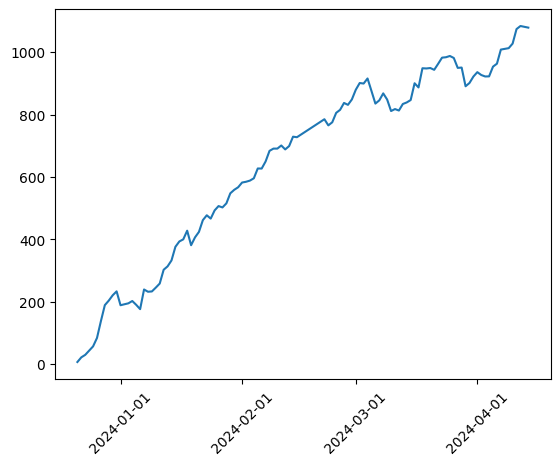

(np.float64(1078.7192989444934), 820, np.float64(0.13155113401762114))

In [58]:
calculate_season_profitability(2023)

## Initial season by season profitability
Starting bets in Jan of the NBA season results in pretty strong results.

******* CALCULATING SEASON **********
2020


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9694444444444444
Test accuracy: 0.7298050139275766


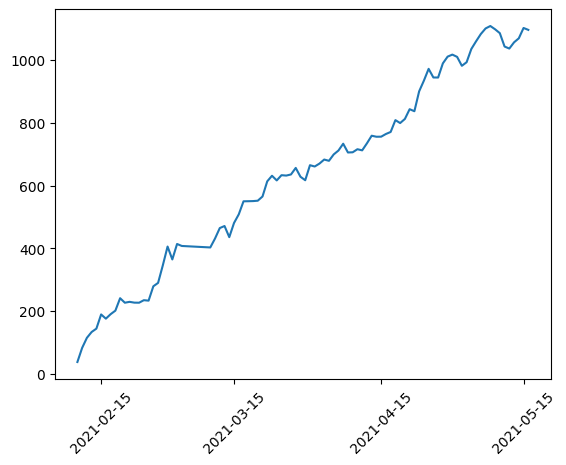

Profit: 1096.5286698474158
Total Wagered: 7180
Profitability: 0.15271987045228633
******* CALCULATING SEASON **********
2021


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9585365853658536
Test accuracy: 0.7341463414634146


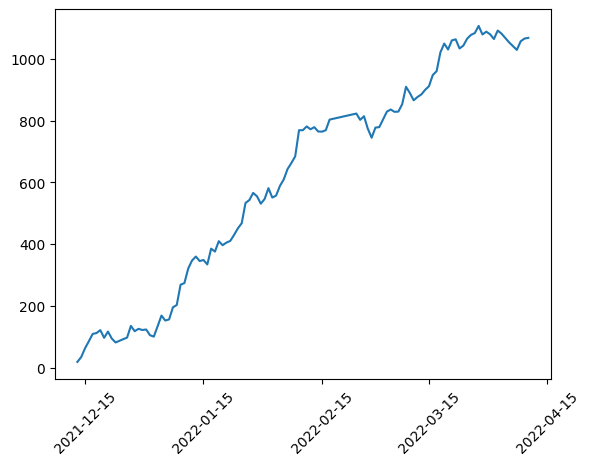

Profit: 1067.5879428717362
Total Wagered: 8200
Profitability: 0.13019365156972393
******* CALCULATING SEASON **********
2022


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9318734793187348
Test accuracy: 0.6792682926829269


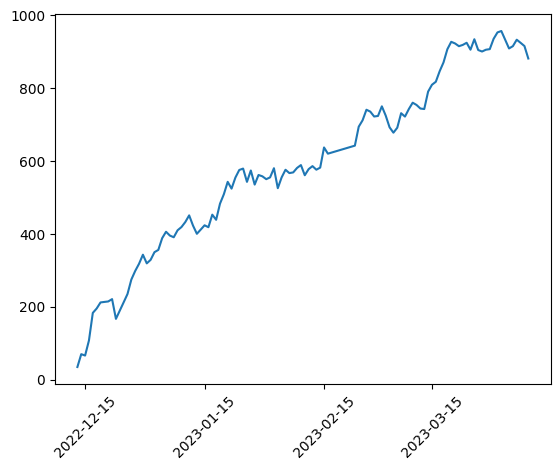

Profit: 881.5701215323159
Total Wagered: 8200
Profitability: 0.10750855140637998
******* CALCULATING SEASON **********
2023


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


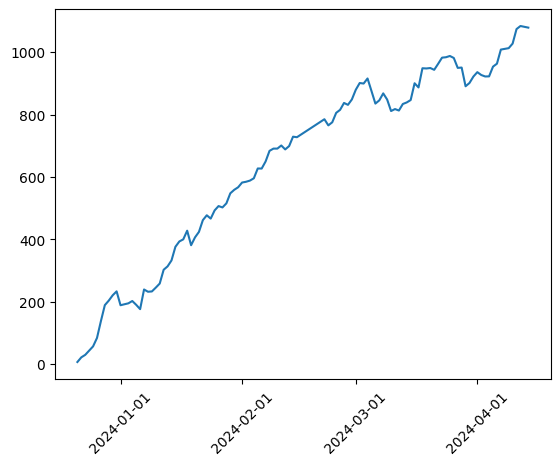

Profit: 1078.7192989444934
Total Wagered: 8200
Profitability: 0.13155113401762114


In [59]:
for i in range(2020, 2024):
  print("******* CALCULATING SEASON **********")
  print(i)
  profit, total_wagers, profitability = calculate_season_profitability(i)
  print(f"Profit: {profit}")
  print(f"Total Wagered: {total_wagers * 10 }")
  print(f"Profitability: {profitability}")

In [60]:
nba_games_with_moneylines.to_csv('data/04_improved_model_with_moneylines.csv', index=False)